In [1]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import time

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


## Exploring training capabilities with GPUs and pytorch

### First define the network and datasets

For this example we have a classification problem with only 2 classes, dogs and cats. We have a train dataset of 18745 items and a test dataset of 6253 items.

In [2]:
#Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Dataset location
TRAIN_DATA_PATH = "../Data/CATS_DOGS/train"
TEST_DATA_PATH = "../Data/CATS_DOGS/test"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])


We use a simple custom CNN for this problem

In [3]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(20, 32, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = torch.nn.Linear((64*17*17), 50)
        self.fc2 = torch.nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, (64*17*17))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)

#### This command show interesting information about the network

In [4]:
testNet = Network()
testNet.to(device)
summary(testNet, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 148, 148]             560
            Conv2d-2           [-1, 32, 72, 72]           5,792
            Conv2d-3           [-1, 64, 34, 34]          18,496
            Linear-4                   [-1, 50]         924,850
            Linear-5                    [-1, 1]              51
Total params: 949,749
Trainable params: 949,749
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 5.17
Params size (MB): 3.62
Estimated Total Size (MB): 9.05
----------------------------------------------------------------


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


This shows an estimated total size of arround 9M
This should be the memory requirements but only for the model.

#### What is the amount of memory needed for training or test dataset?

In [22]:
print("This is the shape of the training batch")
print(img.shape)
print("And every element is of type")
print(img.dtype)
print("So the memory requirements for this batch are: {} MB".format((img.shape[0] * img.shape[1] * img.shape[2] * img.shape[3] * 4) / 1024 /1024))

This is the shape of the training batch
torch.Size([64, 3, 160, 160])
And every element is of type
torch.float32
So the memory requirements for this batch are: 18.75 MB


#### Define test and training functions

In [5]:
def test():
    #Sets the module in evaluation mode
    network.eval()
    test_loss = 0
    correct = 0
    #correct.to(device)
    
    #dont update dynamic computation graph
    with torch.no_grad():
        #for every example in test
        for data, target in test_data_loader:
            
            target = target.view(-1, 1).float()
            target.to(device)
            
            #evaluate the model
            output = network(data.to(device))
            
            #acumulate the loss
            test_loss += F.binary_cross_entropy(output, target.to(device)).item()
            
            pred_cls = output.round()
            correct += pred_cls.eq(target.view(-1, 1).to(device)).sum() 
        
    test_loss /= len(test_data_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_data_loader.dataset), 100. * correct / len(test_data_loader.dataset)))

In [6]:
def train(test_on_every_epoch = False):
    
    for epoch in range(1, num_epochs+1):
    
        
        if test_on_every_epoch:
            test()
        
        start = time.time()
  
        for batch_idx, (data, target) in enumerate(train_data_loader):
        
            network.train()
        
            #forward pass
            out = network(data.to(device))
        
            #Use negative log likelihood loss.
            loss = criterion(out, target.view(-1, 1).float().to(device))
        
        
            #with this gradients are calculated
            loss.backward()
    
            #update gradients
            optimizer.step()
        
            #Set gradients to zero
            optimizer.zero_grad()

            #Display iteration statistics
            if batch_idx % log_interval == 0:
            
                #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_data_loader.dataset),100. * batch_idx / len(train_data_loader), loss.item()))
    
        end = time.time()
        print('Time: {} '.format(end - start))
    

### Before analisis, train model to check accuracy

In [8]:
# Hyper parameters
num_epochs = 4
batchsize = 32
batchsize_test = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [9]:
train(True)


Test set: Avg. loss: 0.0218, Accuracy: 3125/6251 (50%)

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.692769
Train Epoch: 1 [1920/18743 (10%)]	Loss: 0.701372
Train Epoch: 1 [3840/18743 (20%)]	Loss: 0.681713


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [5760/18743 (31%)]	Loss: 0.652789
Train Epoch: 1 [7680/18743 (41%)]	Loss: 0.640712
Train Epoch: 1 [9600/18743 (51%)]	Loss: 0.640916
Train Epoch: 1 [11520/18743 (61%)]	Loss: 0.754216
Train Epoch: 1 [13440/18743 (72%)]	Loss: 0.628307
Train Epoch: 1 [15360/18743 (82%)]	Loss: 0.790702
Train Epoch: 1 [17280/18743 (92%)]	Loss: 0.672575
Time: 5.971116304397583 

Test set: Avg. loss: 0.0192, Accuracy: 4156/6251 (66%)

Train Epoch: 2 [0/18743 (0%)]	Loss: 0.621951
Train Epoch: 2 [1920/18743 (10%)]	Loss: 0.571709
Train Epoch: 2 [3840/18743 (20%)]	Loss: 0.541333
Train Epoch: 2 [5760/18743 (31%)]	Loss: 0.601750


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 2 [7680/18743 (41%)]	Loss: 0.650649
Train Epoch: 2 [9600/18743 (51%)]	Loss: 0.589148
Train Epoch: 2 [11520/18743 (61%)]	Loss: 0.473367
Train Epoch: 2 [13440/18743 (72%)]	Loss: 0.657247
Train Epoch: 2 [15360/18743 (82%)]	Loss: 0.660110
Train Epoch: 2 [17280/18743 (92%)]	Loss: 0.479667
Time: 5.925740957260132 

Test set: Avg. loss: 0.0177, Accuracy: 4482/6251 (72%)

Train Epoch: 3 [0/18743 (0%)]	Loss: 0.661343
Train Epoch: 3 [1920/18743 (10%)]	Loss: 0.515026
Train Epoch: 3 [3840/18743 (20%)]	Loss: 0.560851


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 3 [5760/18743 (31%)]	Loss: 0.575047
Train Epoch: 3 [7680/18743 (41%)]	Loss: 0.779205
Train Epoch: 3 [9600/18743 (51%)]	Loss: 0.430149
Train Epoch: 3 [11520/18743 (61%)]	Loss: 0.675153
Train Epoch: 3 [13440/18743 (72%)]	Loss: 0.714605
Train Epoch: 3 [15360/18743 (82%)]	Loss: 0.522694
Train Epoch: 3 [17280/18743 (92%)]	Loss: 0.746789
Time: 5.991588115692139 

Test set: Avg. loss: 0.0167, Accuracy: 4587/6251 (73%)

Train Epoch: 4 [0/18743 (0%)]	Loss: 0.560947
Train Epoch: 4 [1920/18743 (10%)]	Loss: 0.565897


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 4 [3840/18743 (20%)]	Loss: 0.491712
Train Epoch: 4 [5760/18743 (31%)]	Loss: 0.586534
Train Epoch: 4 [7680/18743 (41%)]	Loss: 0.432914
Train Epoch: 4 [9600/18743 (51%)]	Loss: 0.472460
Train Epoch: 4 [11520/18743 (61%)]	Loss: 0.528961
Train Epoch: 4 [13440/18743 (72%)]	Loss: 0.591220
Train Epoch: 4 [15360/18743 (82%)]	Loss: 0.397115
Train Epoch: 4 [17280/18743 (92%)]	Loss: 0.636067
Time: 5.989449977874756 


In [10]:
test()


Test set: Avg. loss: 0.0155, Accuracy: 4741/6251 (76%)



### How number of workers affect GPU utilization

#### One worker

In [10]:
# Hyper parameters
num_epochs = 3
batchsize = 220
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=1)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=1) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [11]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.692540


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [13200/18743 (70%)]	Loss: 0.689040
Time: 45.21055483818054 
Train Epoch: 2 [0/18743 (0%)]	Loss: 0.684297
Train Epoch: 2 [13200/18743 (70%)]	Loss: 0.676478


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Time: 45.3118040561676 
Train Epoch: 3 [0/18743 (0%)]	Loss: 0.659734
Train Epoch: 3 [13200/18743 (70%)]	Loss: 0.657482


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Time: 45.38182520866394 


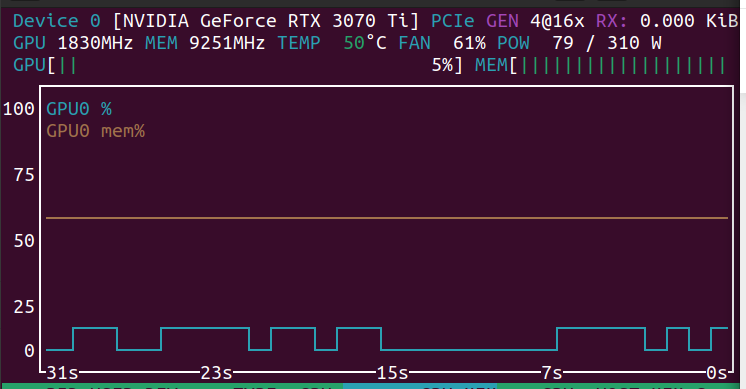

- GPU utilization: 5% avg
- Time spent per epoch: 45s on average

#### Four workers

In [15]:
# Hyper parameters
num_epochs = 3
batchsize = 220
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=4)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=4) 

In [16]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.673807


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [13200/18743 (70%)]	Loss: 0.570708
Time: 12.162627458572388 
Train Epoch: 2 [0/18743 (0%)]	Loss: 0.541120


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 2 [13200/18743 (70%)]	Loss: 0.563633
Time: 12.263587951660156 
Train Epoch: 3 [0/18743 (0%)]	Loss: 0.525775


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 3 [13200/18743 (70%)]	Loss: 0.523678
Time: 12.302703142166138 


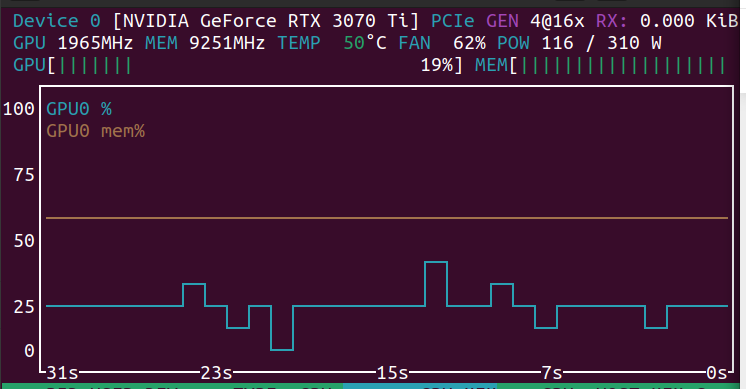

- GPU utilization: 20% avg
- Time spent per epoch: 12s on average

#### Eight workers

In [19]:
# Hyper parameters
num_epochs = 3
batchsize = 220
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=8)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=8) 

In [20]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.660076


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [13200/18743 (70%)]	Loss: 0.545573
Time: 6.958216428756714 
Train Epoch: 2 [0/18743 (0%)]	Loss: 0.669746


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 2 [13200/18743 (70%)]	Loss: 0.558579
Time: 7.237610578536987 
Train Epoch: 3 [0/18743 (0%)]	Loss: 0.635938


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 3 [13200/18743 (70%)]	Loss: 0.558449
Time: 6.975800275802612 


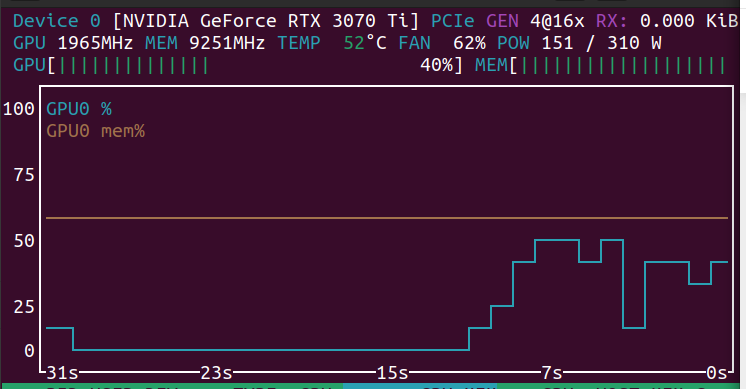

- GPU utilization: 40% avg
- Time spent per epoch: 7s on average

#### Sixteen workers, max for my machine

In [25]:
# Hyper parameters
num_epochs = 3
batchsize = 220
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16)

In [27]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.511894
Train Epoch: 1 [13200/18743 (70%)]	Loss: 0.454676


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Time: 6.089748859405518 
Train Epoch: 2 [0/18743 (0%)]	Loss: 0.448466


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 2 [13200/18743 (70%)]	Loss: 0.496250
Time: 6.118439435958862 
Train Epoch: 3 [0/18743 (0%)]	Loss: 0.561314


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 3 [13200/18743 (70%)]	Loss: 0.424811
Time: 6.225910425186157 


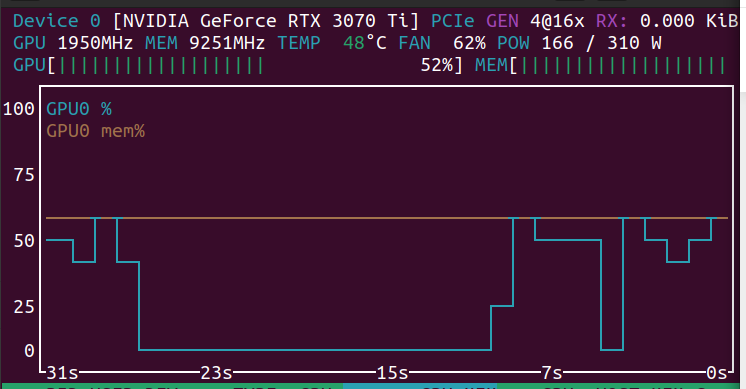

- GPU utilization: 48% avg
- Time spent per epoch: 6.1s on average

#### Why incrementing workers in loaders, also increment GPU utilization?

GPU, as everithing has limited resources, if you want to use all of those, you have to provide it with work. During training this work is sent by pytorch in the form of, one, the model to be trained, and second, the input batch in form of tensors. The input is stored in the host computer in the form of images.
GPU might not be as fast as CPU in doing one task, but it is great when doing multiple task, so for keep the GPU working you have to provide a lot of parallel work, this means you have to read lots of images from host. Here is were workers comes in. 
There is a sweet point in which when GPU finishes its work and is ready to process more, and host has to be ready to send more work. If you have enough workers to satisfy to be in this point, then you are maximizing GPU in terms of workers in loaders, in my example I only have 8 cores and 16 threads, so my limit is 16, but if I check the diference in performance between 8 an 16, it's clear that between those is the sweet point of workers.

### How batch size affect GPU utilization

#### Batch of 1

In [18]:
# Hyper parameters
num_epochs = 1
batchsize = 1
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [19]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.813944
Train Epoch: 1 [60/18743 (0%)]	Loss: 0.645846
Train Epoch: 1 [120/18743 (1%)]	Loss: 0.719396
Train Epoch: 1 [180/18743 (1%)]	Loss: 0.766529
Train Epoch: 1 [240/18743 (1%)]	Loss: 0.759638
Train Epoch: 1 [300/18743 (2%)]	Loss: 0.681945
Train Epoch: 1 [360/18743 (2%)]	Loss: 0.707101
Train Epoch: 1 [420/18743 (2%)]	Loss: 0.703648
Train Epoch: 1 [480/18743 (3%)]	Loss: 0.674178
Train Epoch: 1 [540/18743 (3%)]	Loss: 0.643819
Train Epoch: 1 [600/18743 (3%)]	Loss: 0.689794
Train Epoch: 1 [660/18743 (4%)]	Loss: 0.654007
Train Epoch: 1 [720/18743 (4%)]	Loss: 0.730227
Train Epoch: 1 [780/18743 (4%)]	Loss: 0.641312
Train Epoch: 1 [840/18743 (4%)]	Loss: 0.657592
Train Epoch: 1 [900/18743 (5%)]	Loss: 0.715145
Train Epoch: 1 [960/18743 (5%)]	Loss: 0.667943
Train Epoch: 1 [1020/18743 (5%)]	Loss: 0.683232
Train Epoch: 1 [1080/18743 (6%)]	Loss: 0.629781
Train Epoch: 1 [1140/18743 (6%)]	Loss: 0.660424
Train Epoch: 1 [1200/18743 (6%)]	Loss: 0.669846
Train Epoch:

/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [4080/18743 (22%)]	Loss: 0.712683
Train Epoch: 1 [4140/18743 (22%)]	Loss: 0.592819
Train Epoch: 1 [4200/18743 (22%)]	Loss: 0.639923
Train Epoch: 1 [4260/18743 (23%)]	Loss: 0.889204
Train Epoch: 1 [4320/18743 (23%)]	Loss: 0.551788
Train Epoch: 1 [4380/18743 (23%)]	Loss: 0.621727
Train Epoch: 1 [4440/18743 (24%)]	Loss: 0.665961
Train Epoch: 1 [4500/18743 (24%)]	Loss: 0.661161
Train Epoch: 1 [4560/18743 (24%)]	Loss: 0.665694
Train Epoch: 1 [4620/18743 (25%)]	Loss: 0.667451
Train Epoch: 1 [4680/18743 (25%)]	Loss: 0.745383
Train Epoch: 1 [4740/18743 (25%)]	Loss: 0.738667
Train Epoch: 1 [4800/18743 (26%)]	Loss: 0.648558
Train Epoch: 1 [4860/18743 (26%)]	Loss: 0.703818
Train Epoch: 1 [4920/18743 (26%)]	Loss: 0.661466
Train Epoch: 1 [4980/18743 (27%)]	Loss: 0.640332
Train Epoch: 1 [5040/18743 (27%)]	Loss: 0.268421
Train Epoch: 1 [5100/18743 (27%)]	Loss: 0.671395
Train Epoch: 1 [5160/18743 (28%)]	Loss: 0.641022
Train Epoch: 1 [5220/18743 (28%)]	Loss: 0.641498
Train Epoch: 1 [5280

Train Epoch: 1 [14040/18743 (75%)]	Loss: 0.065329
Train Epoch: 1 [14100/18743 (75%)]	Loss: 0.997808
Train Epoch: 1 [14160/18743 (76%)]	Loss: 0.480432
Train Epoch: 1 [14220/18743 (76%)]	Loss: 0.814691
Train Epoch: 1 [14280/18743 (76%)]	Loss: 0.613775
Train Epoch: 1 [14340/18743 (77%)]	Loss: 0.690993
Train Epoch: 1 [14400/18743 (77%)]	Loss: 0.597918
Train Epoch: 1 [14460/18743 (77%)]	Loss: 0.908727
Train Epoch: 1 [14520/18743 (77%)]	Loss: 0.754511
Train Epoch: 1 [14580/18743 (78%)]	Loss: 0.527498
Train Epoch: 1 [14640/18743 (78%)]	Loss: 0.698328
Train Epoch: 1 [14700/18743 (78%)]	Loss: 0.455992
Train Epoch: 1 [14760/18743 (79%)]	Loss: 0.282806
Train Epoch: 1 [14820/18743 (79%)]	Loss: 0.797621
Train Epoch: 1 [14880/18743 (79%)]	Loss: 0.811856
Train Epoch: 1 [14940/18743 (80%)]	Loss: 0.837693
Train Epoch: 1 [15000/18743 (80%)]	Loss: 0.822989
Train Epoch: 1 [15060/18743 (80%)]	Loss: 0.289332
Train Epoch: 1 [15120/18743 (81%)]	Loss: 0.180935
Train Epoch: 1 [15180/18743 (81%)]	Loss: 0.376402


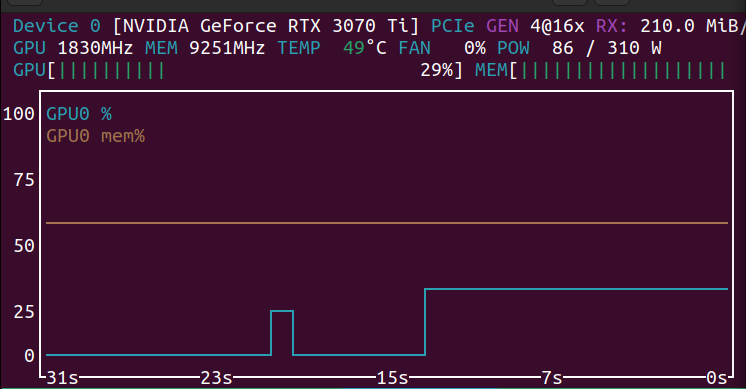

- GPU utilization: 29% avg
- Time spent per epoch: 36.8s on average

#### Batch of 4

In [20]:
# Hyper parameters
num_epochs = 1
batchsize = 4
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [22]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.238274
Train Epoch: 1 [240/18743 (1%)]	Loss: 0.233563
Train Epoch: 1 [480/18743 (3%)]	Loss: 2.111903
Train Epoch: 1 [720/18743 (4%)]	Loss: 0.620815
Train Epoch: 1 [960/18743 (5%)]	Loss: 0.417441
Train Epoch: 1 [1200/18743 (6%)]	Loss: 0.412211
Train Epoch: 1 [1440/18743 (8%)]	Loss: 0.897875
Train Epoch: 1 [1680/18743 (9%)]	Loss: 0.598978
Train Epoch: 1 [1920/18743 (10%)]	Loss: 1.459675
Train Epoch: 1 [2160/18743 (12%)]	Loss: 0.321146
Train Epoch: 1 [2400/18743 (13%)]	Loss: 0.295985
Train Epoch: 1 [2640/18743 (14%)]	Loss: 0.548423
Train Epoch: 1 [2880/18743 (15%)]	Loss: 0.229943
Train Epoch: 1 [3120/18743 (17%)]	Loss: 0.792531
Train Epoch: 1 [3360/18743 (18%)]	Loss: 0.392385
Train Epoch: 1 [3600/18743 (19%)]	Loss: 0.363568
Train Epoch: 1 [3840/18743 (20%)]	Loss: 0.526500
Train Epoch: 1 [4080/18743 (22%)]	Loss: 1.005234
Train Epoch: 1 [4320/18743 (23%)]	Loss: 0.459051
Train Epoch: 1 [4560/18743 (24%)]	Loss: 0.654986
Train Epoch: 1 [4800/18743 (26%)]	L

/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [7680/18743 (41%)]	Loss: 0.288070
Train Epoch: 1 [7920/18743 (42%)]	Loss: 0.632411
Train Epoch: 1 [8160/18743 (44%)]	Loss: 0.693498
Train Epoch: 1 [8400/18743 (45%)]	Loss: 0.302654
Train Epoch: 1 [8640/18743 (46%)]	Loss: 0.190930
Train Epoch: 1 [8880/18743 (47%)]	Loss: 0.906240
Train Epoch: 1 [9120/18743 (49%)]	Loss: 0.526148
Train Epoch: 1 [9360/18743 (50%)]	Loss: 0.761630
Train Epoch: 1 [9600/18743 (51%)]	Loss: 0.352610
Train Epoch: 1 [9840/18743 (52%)]	Loss: 0.264922
Train Epoch: 1 [10080/18743 (54%)]	Loss: 0.107843
Train Epoch: 1 [10320/18743 (55%)]	Loss: 0.180634
Train Epoch: 1 [10560/18743 (56%)]	Loss: 0.415393
Train Epoch: 1 [10800/18743 (58%)]	Loss: 0.739291
Train Epoch: 1 [11040/18743 (59%)]	Loss: 0.492257
Train Epoch: 1 [11280/18743 (60%)]	Loss: 0.280071
Train Epoch: 1 [11520/18743 (61%)]	Loss: 0.416102
Train Epoch: 1 [11760/18743 (63%)]	Loss: 0.427065
Train Epoch: 1 [12000/18743 (64%)]	Loss: 0.530352
Train Epoch: 1 [12240/18743 (65%)]	Loss: 0.239479
Train Epoc

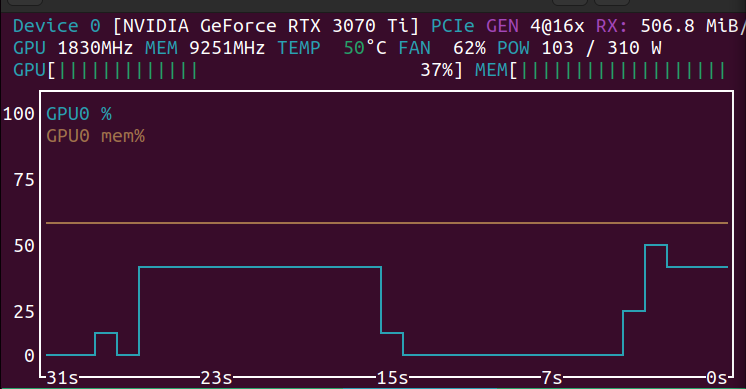

- GPU utilization: 37% avg
- Time spent per epoch: 12s on average

#### Batch of 8

In [27]:
# Hyper parameters
num_epochs = 1
batchsize = 8
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [26]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.542823
Train Epoch: 1 [480/18743 (3%)]	Loss: 0.854276
Train Epoch: 1 [960/18743 (5%)]	Loss: 0.722248


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [1440/18743 (8%)]	Loss: 0.541631
Train Epoch: 1 [1920/18743 (10%)]	Loss: 0.537276
Train Epoch: 1 [2400/18743 (13%)]	Loss: 0.612322
Train Epoch: 1 [2880/18743 (15%)]	Loss: 0.876929
Train Epoch: 1 [3360/18743 (18%)]	Loss: 0.493273
Train Epoch: 1 [3840/18743 (20%)]	Loss: 0.587868
Train Epoch: 1 [4320/18743 (23%)]	Loss: 0.845150
Train Epoch: 1 [4800/18743 (26%)]	Loss: 0.698476
Train Epoch: 1 [5280/18743 (28%)]	Loss: 0.761289
Train Epoch: 1 [5760/18743 (31%)]	Loss: 0.427496
Train Epoch: 1 [6240/18743 (33%)]	Loss: 0.504200
Train Epoch: 1 [6720/18743 (36%)]	Loss: 1.126457
Train Epoch: 1 [7200/18743 (38%)]	Loss: 0.515638
Train Epoch: 1 [7680/18743 (41%)]	Loss: 0.410997
Train Epoch: 1 [8160/18743 (44%)]	Loss: 0.342332
Train Epoch: 1 [8640/18743 (46%)]	Loss: 0.432474
Train Epoch: 1 [9120/18743 (49%)]	Loss: 0.382789
Train Epoch: 1 [9600/18743 (51%)]	Loss: 0.329908
Train Epoch: 1 [10080/18743 (54%)]	Loss: 0.416238
Train Epoch: 1 [10560/18743 (56%)]	Loss: 0.635749
Train Epoch: 1 [110

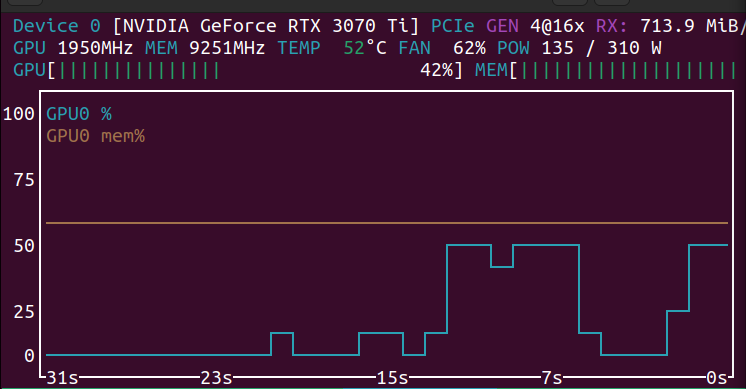

- GPU utilization: 42% avg
- Time spent per epoch: 8.3s on average

#### Batch of 16

In [28]:
# Hyper parameters
num_epochs = 1
batchsize = 16
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [29]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.706230
Train Epoch: 1 [960/18743 (5%)]	Loss: 0.685502
Train Epoch: 1 [1920/18743 (10%)]	Loss: 0.688929
Train Epoch: 1 [2880/18743 (15%)]	Loss: 0.671078
Train Epoch: 1 [3840/18743 (20%)]	Loss: 0.669213
Train Epoch: 1 [4800/18743 (26%)]	Loss: 0.695400
Train Epoch: 1 [5760/18743 (31%)]	Loss: 0.670028
Train Epoch: 1 [6720/18743 (36%)]	Loss: 0.652141
Train Epoch: 1 [7680/18743 (41%)]	Loss: 0.648038
Train Epoch: 1 [8640/18743 (46%)]	Loss: 0.552682
Train Epoch: 1 [9600/18743 (51%)]	Loss: 0.570160
Train Epoch: 1 [10560/18743 (56%)]	Loss: 0.632904
Train Epoch: 1 [11520/18743 (61%)]	Loss: 0.618638
Train Epoch: 1 [12480/18743 (67%)]	Loss: 0.654847
Train Epoch: 1 [13440/18743 (72%)]	Loss: 0.611041


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [14400/18743 (77%)]	Loss: 0.645741
Train Epoch: 1 [15360/18743 (82%)]	Loss: 0.540716
Train Epoch: 1 [16320/18743 (87%)]	Loss: 0.753582
Train Epoch: 1 [17280/18743 (92%)]	Loss: 0.637608
Train Epoch: 1 [18240/18743 (97%)]	Loss: 0.686845
Time: 6.758173227310181 


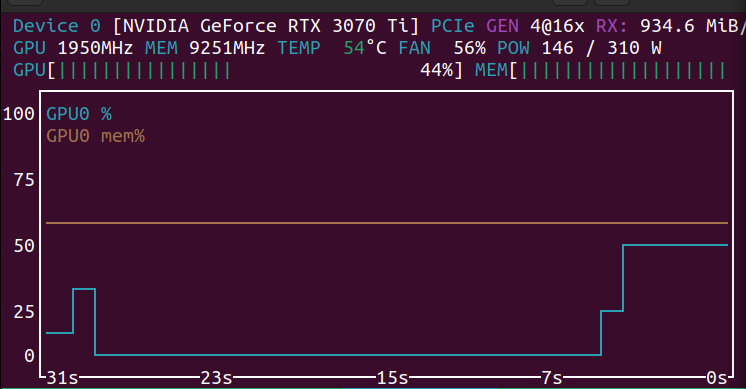

- GPU utilization: 44% avg
- Time spent per epoch: 6.75s on average

#### Bigger batch

In [55]:
# Hyper parameters
num_epochs = 1
batchsize = 400
batchsize_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [57]:
train()

/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [0/18743 (0%)]	Loss: 0.691611
Time: 6.820275545120239 


- Batch 32: gpu 52% and 6.05s
- Batch 64: gpu 56% and 6.07s
- Batch 128: gpu 59% and 6.28s
- Batch 256: gpu 58% and 6.36s

#### So what?

Interesting, if we increase batch size from 1 up to 16 with the current model and input image, time and GPU utilization have a big increase each step, but then it seems to reach the celing, getting it best time performance at 32 batch size. On the other hand having a bigger batch size seems to also increase GPU utilization, but this doesn't help in time.

I think this behavior is because my CPU is the bottle neck, the max number of images I can process asynchronuslly is 16, that's why increasing batch size bigger than that doesn't help a lot.

However, having a big batch size is not always the best option to increase accuracy, next I'll try changing image size input.

### Changing input size 250 * 250

In [7]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [8]:
class Network2(torch.nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(20, 32, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = torch.nn.Linear((64*29*29), 50)
        self.fc2 = torch.nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, (64*29*29))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)

In [9]:
# Hyper parameters
num_epochs = 1
batchsize = 32
batchsize_test = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network2()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [11]:
summary(network, (3, 250, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 248, 248]             560
            Conv2d-2         [-1, 32, 122, 122]           5,792
            Conv2d-3           [-1, 64, 59, 59]          18,496
            Linear-4                   [-1, 50]       2,691,250
            Linear-5                    [-1, 1]              51
Total params: 2,716,149
Trainable params: 2,716,149
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.72
Forward/backward pass size (MB): 14.72
Params size (MB): 10.36
Estimated Total Size (MB): 25.80
----------------------------------------------------------------


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [13]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.675711
Train Epoch: 1 [1920/18743 (10%)]	Loss: 0.649287
Train Epoch: 1 [3840/18743 (20%)]	Loss: 0.712623
Train Epoch: 1 [5760/18743 (31%)]	Loss: 0.587964
Train Epoch: 1 [7680/18743 (41%)]	Loss: 0.620047
Train Epoch: 1 [9600/18743 (51%)]	Loss: 0.627532
Train Epoch: 1 [11520/18743 (61%)]	Loss: 0.717994
Train Epoch: 1 [13440/18743 (72%)]	Loss: 0.709728
Train Epoch: 1 [15360/18743 (82%)]	Loss: 0.604133


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [17280/18743 (92%)]	Loss: 0.655093
Time: 11.01717758178711 


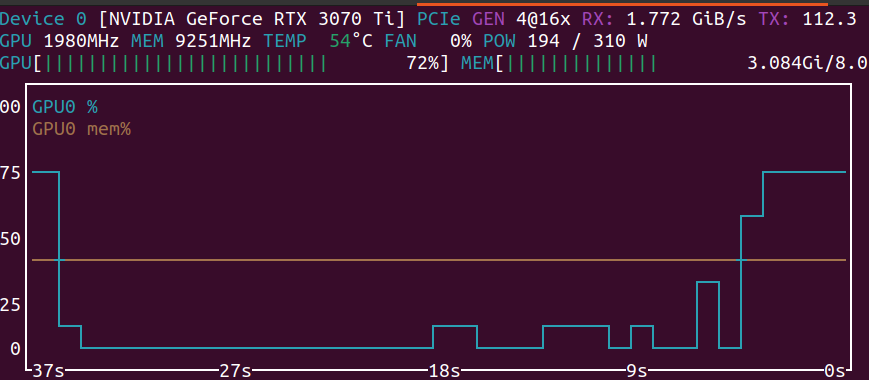

- GPU utilization: 72% avg
- Time spent per epoch: 11s on average

### Changing input size 300 * 300

In [14]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [23]:
class Network3(torch.nn.Module):
    def __init__(self):
        super(Network3, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(20, 32, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = torch.nn.Linear((64*35*35), 50)
        self.fc2 = torch.nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, (64*35*35))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)

In [24]:
# Hyper parameters
num_epochs = 1
batchsize = 32
batchsize_test = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 60

#Network model
network = Network3()
network.to(device)

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
#Binary cross entropy loss
criterion = torch.nn.BCELoss()

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batchsize_test, shuffle=True, num_workers=16) 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

In [25]:
summary(network, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 298, 298]             560
            Conv2d-2         [-1, 32, 147, 147]           5,792
            Conv2d-3           [-1, 64, 71, 71]          18,496
            Linear-4                   [-1, 50]       3,920,050
            Linear-5                    [-1, 1]              51
Total params: 3,944,949
Trainable params: 3,944,949
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.03
Forward/backward pass size (MB): 21.29
Params size (MB): 15.05
Estimated Total Size (MB): 37.37
----------------------------------------------------------------


In [26]:
train()

Train Epoch: 1 [0/18743 (0%)]	Loss: 0.704699
Train Epoch: 1 [1920/18743 (10%)]	Loss: 0.686811
Train Epoch: 1 [3840/18743 (20%)]	Loss: 0.683031
Train Epoch: 1 [5760/18743 (31%)]	Loss: 0.654118
Train Epoch: 1 [7680/18743 (41%)]	Loss: 0.671515
Train Epoch: 1 [9600/18743 (51%)]	Loss: 0.679789
Train Epoch: 1 [11520/18743 (61%)]	Loss: 0.612037


/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Epoch: 1 [13440/18743 (72%)]	Loss: 0.671714
Train Epoch: 1 [15360/18743 (82%)]	Loss: 0.590322
Train Epoch: 1 [17280/18743 (92%)]	Loss: 0.687761
Time: 14.696714639663696 


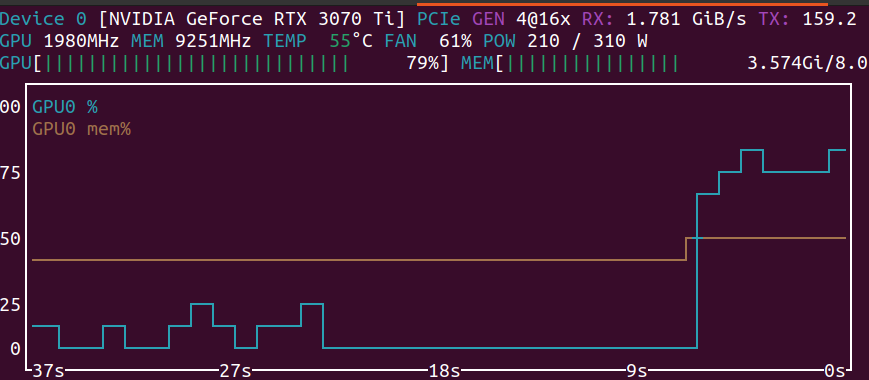

- GPU utilization: 79% avg
- Time spent per epoch: 14s on average

#### So what?

When changing input image but maintain the network architecture (only changing the size of some layers due to the change in the input), the number of parameters and the memory of the model increases linearly. Also GPU utilization reaches almost 80%. This is because the size of the matrix multiplication increases and more work can be done in parallel. However increasing the number of the input might not be the best solution specially with big models.

So far GPU memory usage has been moderate, but for big models this won't be the case.
Next, I'll try to use a big model for this problem and 

In [15]:
#just for testing
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=16)

test = iter(train_data_loader)
img, target= next(test)

In [16]:
img.shape

torch.Size([32, 3, 300, 300])

In [17]:
conv1 = torch.nn.Conv2d(3, 20, kernel_size=3)
conv2 = torch.nn.Conv2d(20, 32, kernel_size=3)
conv3 = torch.nn.Conv2d(32, 64, kernel_size=3)
fc1 = torch.nn.Linear((64*17*17), 50)
fc2 = torch.nn.Linear(50, 1)

x = F.relu(F.max_pool2d(conv1(img), 2))
x = F.relu(F.max_pool2d(conv2(x), 2))
x = F.relu(F.max_pool2d(conv3(x), 2))
#x = x.view(-1, (64*23*23))

x.shape
#x = F.relu(self.fc1(x))
#x = F.dropout(x)

torch.Size([32, 64, 35, 35])

### Train model

In [11]:
print("torch.cuda.memory_allocated: %fMB"%(torch.cuda.memory_allocated(0)/1024/1024))
print("torch.cuda.memory_reserved: %fMB"%(torch.cuda.memory_reserved(0)/1024/1024))
print("torch.cuda.max_memory_reserved: %fMB"%(torch.cuda.max_memory_reserved(0)/1024/1024))


torch.cuda.memory_allocated: 1016.760254MB
torch.cuda.memory_reserved: 1718.000000MB
torch.cuda.max_memory_reserved: 1718.000000MB


### ToDo

- Create a section in which the network is described
- Create sections to show how changing num of workers, batch size, optimizes training time
- Check other kind of accuaracy measurements
- Check how to maximize utilization of GPU, does this affect training results?
- Monitor gpu usage, memory, SM usage?